In [29]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [30]:
api_wrapper_arxiv  = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [31]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [32]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [33]:
wiki.invoke("What is Machine Learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [34]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-Agent"

In [35]:
###Custom functions
def multiply(a:int, b:int) -> int:
    """Multipy a and b.
    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a:int, b:int) -> int:
    """Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a:int, b:int) -> int:
    """Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [arxiv, wiki, add, multiply, divide]

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [37]:
tools = [arxiv, wiki, tavily, add, multiply, divide]

In [38]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model = "gpt-4")
model_with_tools = model.bind_tools(tools)

In [39]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
model_with_tools.invoke([HumanMessage(content=f"What is the recent AI News?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DpWNuulVwAaDdUb3MEaSXLFD', 'function': {'arguments': '{\n  "query": "recent AI news"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 341, 'total_tokens': 362, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BrSKpRcZoBnhO2HR5lezyn4aC26pS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2ef63b64-eea5-4c42-912e-a2d7ca2afee4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'call_DpWNuulVwAaDdUb3MEaSXLFD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 341, 'output_tokens': 21, 'total_tokens'

In [40]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

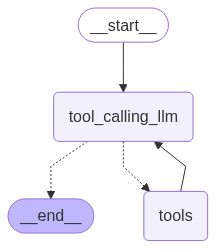

In [41]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message(result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news and add 5 plus 6 and multipy by 59")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news and add 5 plus 6 and multipy by 59
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_kHWGwXRAnSMgKH0tM7vrB7yZ)
 Call ID: call_kHWGwXRAnSMgKH0tM7vrB7yZ
  Args:
    query: recent AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in June - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-june-2025/", "content": "# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] a text card reading \"A

In [43]:
messages = graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (call_TweBzVAqhjdaZEFsEljS2QCE)
 Call ID: call_TweBzVAqhjdaZEFsEljS2QCE
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

5 plus 8 is 13.


In [44]:
messages = [HumanMessage(content=f"Divide that by 5")]
messages = graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

Sorry, could you specify what should I divide by 5?


In [45]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message(result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")



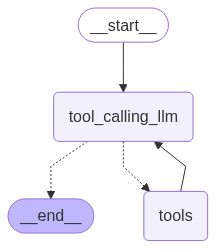

In [46]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [47]:
config = {"configurable":{"thread_id":"1"}}
messages = [HumanMessage(content=f"Add 12 and 13")]
messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (call_NY5K4lrQBcQepjjCw3kaXXTb)
 Call ID: call_NY5K4lrQBcQepjjCw3kaXXTb
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.


In [48]:
messages = [HumanMessage(content=f"Add that number to 33")]
messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (call_NY5K4lrQBcQepjjCw3kaXXTb)
 Call ID: call_NY5K4lrQBcQepjjCw3kaXXTb
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

Add that number to 33
================================== Ai Message ==================================
Tool Calls:
  add (call_1QatdE9t8ndjTVwa218KeIGh)
 Call ID: call_1QatdE9t8ndjTVwa218KeIGh
  Args:
    a: 25
    b: 33
================================= Tool Message =================================
Name: add

58
================================== Ai Message ==================================

The sum of 25 and 33

In [49]:
messages = [HumanMessage(content=f"and then divide that number to 7")]
messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (call_NY5K4lrQBcQepjjCw3kaXXTb)
 Call ID: call_NY5K4lrQBcQepjjCw3kaXXTb
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

Add that number to 33
================================== Ai Message ==================================
Tool Calls:
  add (call_1QatdE9t8ndjTVwa218KeIGh)
 Call ID: call_1QatdE9t8ndjTVwa218KeIGh
  Args:
    a: 25
    b: 33
================================= Tool Message =================================
Name: add

58
================================== Ai Message ==================================

The sum of 25 and 33